In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import glob
import cv2
from PIL import Image
import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
%matplotlib inline

model_name = 'MobileNet'

!mkdir './MobileNet'
save_MobileNet = './MobileNet/'

mkdir: cannot create directory ‘./MobileNet’: File exists


## Preparing Dataset

In [3]:
dir_name = '../input/intel-image-classification/'

train_path = os.path.join(dir_name, 'seg_train/seg_train/')

val_path = os.path.join(dir_name, 'seg_test/seg_test/')

In [4]:
train_path = '../input/intel-image-classification/seg_train/seg_train/'

val_path = '../input/intel-image-classification/seg_test/seg_test/'

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_path,
                                                   target_size=(300,300),
                                                   batch_size=128,
                                                   class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(val_path,
                                                      target_size=(300,300),
                                                      batch_size=128,
                                                      class_mode='categorical', shuffle=False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [6]:
class_indices = train_generator.class_indices
label = dict((v,k) for k,v in class_indices.items())
label

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [7]:
x, y = train_generator.next()
print("Shape of image batch: ", x.shape)
print("Shape of label batch: ", y.shape)

Shape of image batch:  (128, 300, 300, 3)
Shape of label batch:  (128, 6)


## Vizualize Data

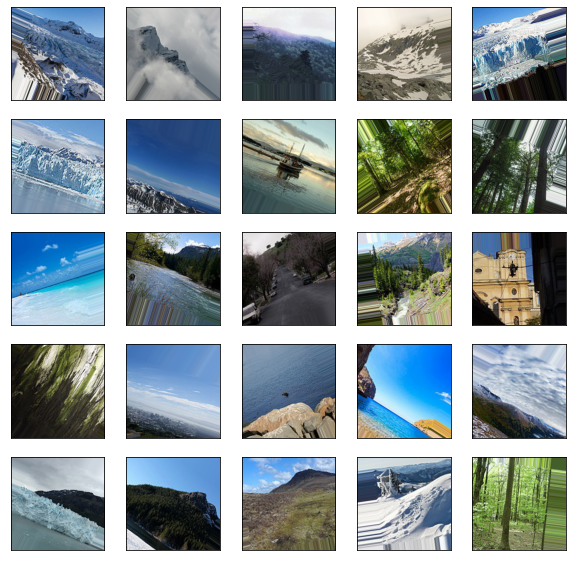

In [8]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[i], cmap=plt.cm.binary)
    
plt.show()

## Model

In [9]:
mobileNet_base = MobileNet(include_top=False, pooling=None, input_shape=(300, 300, 3))

inner = mobileNet_base.output

inner = Flatten()(inner)
inner = Dense(units=256, activation='relu')(inner)
inner = Dropout(rate=0.2)(inner)
inner = Dense(units=6, activation='softmax')(inner)

model = Model(inputs=mobileNet_base.input, outputs=inner)

model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 150, 150, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 150, 150, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 150, 150, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 150, 150, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 150, 150, 32)      128       
______________________________________________________________

In [14]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

model_save_callback = ModelCheckpoint(filepath='./model-epoch{epoch:03d}-acc-{val_accuracy:.3f}.h5',
                                     monitor='val_accuracy',
                                     mode='max',
                                     verbose=1, save_best_only=False, save_weights_only=True)

early_stop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=15, verbose=1, mode='max')

In [15]:
steps = train_generator.samples / train_generator.batch_size

In [16]:
history = model.fit(train_generator,
                    steps_per_epoch=steps,
                    validation_data=validation_generator,
                    validation_steps=1,
                    epochs=20,
                    callbacks=[model_save_callback, early_stop_callback],
                    verbose=1)

Epoch 1/20
109/109 [==============================] - 327s 3s/step - loss: 0.5164 - accuracy: 0.8279 - val_loss: 4.9392 - val_accuracy: 0.2969

Epoch 00001: saving model to ./model-epoch001-acc-0.297.h5
Epoch 2/20
109/109 [==============================] - 323s 3s/step - loss: 0.3367 - accuracy: 0.8850 - val_loss: 3.5330 - val_accuracy: 0.4062

Epoch 00002: saving model to ./model-epoch002-acc-0.406.h5
Epoch 3/20
109/109 [==============================] - 323s 3s/step - loss: 0.3350 - accuracy: 0.8895 - val_loss: 0.9884 - val_accuracy: 0.6484

Epoch 00003: saving model to ./model-epoch003-acc-0.648.h5
Epoch 4/20
109/109 [==============================] - 327s 3s/step - loss: 0.3101 - accuracy: 0.9024 - val_loss: 46.2846 - val_accuracy: 0.0000e+00

Epoch 00004: saving model to ./model-epoch004-acc-0.000.h5
Epoch 5/20
109/109 [==============================] - 326s 3s/step - loss: 0.2915 - accuracy: 0.9073 - val_loss: 1.3714 - val_accuracy: 0.5781

Epoch 00005: saving model to ./model-ep

In [17]:
model.save('intel_image_classifier_mobilenetv2.h5')

## Evaluation

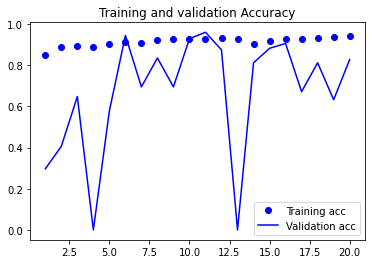

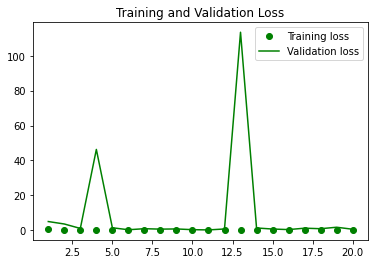

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [23]:
predict = model.predict_generator(validation_generator, max_queue_size=256)
predict_t = np.argmax(predict, axis=1)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [27]:
class_labels = list(validation_generator.class_indices.keys())

cls_report = classification_report(validation_generator.classes, predict_t, target_names=class_labels)
print(cls_report)

              precision    recall  f1-score   support

   buildings       0.98      0.83      0.90       437
      forest       0.99      0.99      0.99       474
     glacier       0.90      0.84      0.87       553
    mountain       0.86      0.90      0.88       525
         sea       0.92      0.96      0.94       510
      street       0.87      0.97      0.92       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.91      3000



In [33]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
            
    cm = confusion_matrix(y_true, y_pred)
    
    classes = list(map(lambda x: classes[x], unique_labels(y_true, y_pred)))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
        
    fig, ax = plt.subplots(figsize=(5,5))
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
        
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax  

Normalized confusion matrix


<AxesSubplot:title={'center':'Confusion matrix, with normalization'}, xlabel='Predicted label', ylabel='True label'>

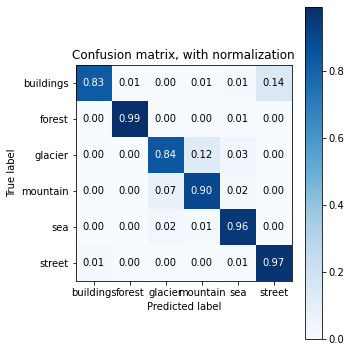

In [34]:
plot_confusion_matrix(validation_generator.classes, predict_t, classes=class_labels, normalize=True, title='Confusion matrix, with normalization')